# Building an image model from results obtained by fitting:

## M51 test data

Initially we fit the M51 test image; then, from the fit results we build a model, and finnaly we subtract the model from the original image.

In [1]:
from astropy.io import fits
image = fits.open("../../test/data/M51.fits")
pixel_data = image[0].data

from ellipse.ellipse import Ellipse
ellipse = Ellipse(pixel_data)
isolist = ellipse.fit_image(sclip=2., nclip=3)

Centering on object....   Done. Found x0 = 257.0, y0 = 258.0
#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
  10.00     1089.59 ( 8.44)  0.102 (0.006)  65.93 ( 2.0)  0.191    60     0   20     0
  11.00     1044.70 ( 7.70)  0.132 (0.005)  72.93 ( 1.1)  0.150    65     0   10     0
  12.10      983.21 ( 5.88)  0.157 (0.003)  70.03 ( 0.6)  0.122    61     9   10     0
  13.31      916.06 ( 7.32)  0.157 (0.006)  49.90 ( 1.3)  0.216    70     7   50     2
  14.64      895.94 ( 6.87)  0.223 (0.004)  55.85 ( 0.7)  0.160    77     4   19     0
  16.11      868.99 ( 5.41)  0.282 (0.003)  51.85 ( 0.5)  0.152    76    10   12     0
  17.72      851.25 ( 5.75)  0.282 (0.003)  43.00 ( 0.3)  0.119    79    15   12     0
  19.49      731.82 ( 4.44)  0.1

Now we build a model image. 

Note that we use a background estimate taken from the data array itself. This is arbitrary though, just for demo purposes in here.

In [2]:
import numpy as np
from ellipse.model import build_model

model_image = build_model(pixel_data, isolist, fill=np.mean(pixel_data[0:10,0:10]))

Interpolating....Done
SMA=131.0
Done


In [3]:
print(pixel_data.shape)
print(model_image.shape)

(512, 512)
(512, 512)


Display (just the central, modeled region):

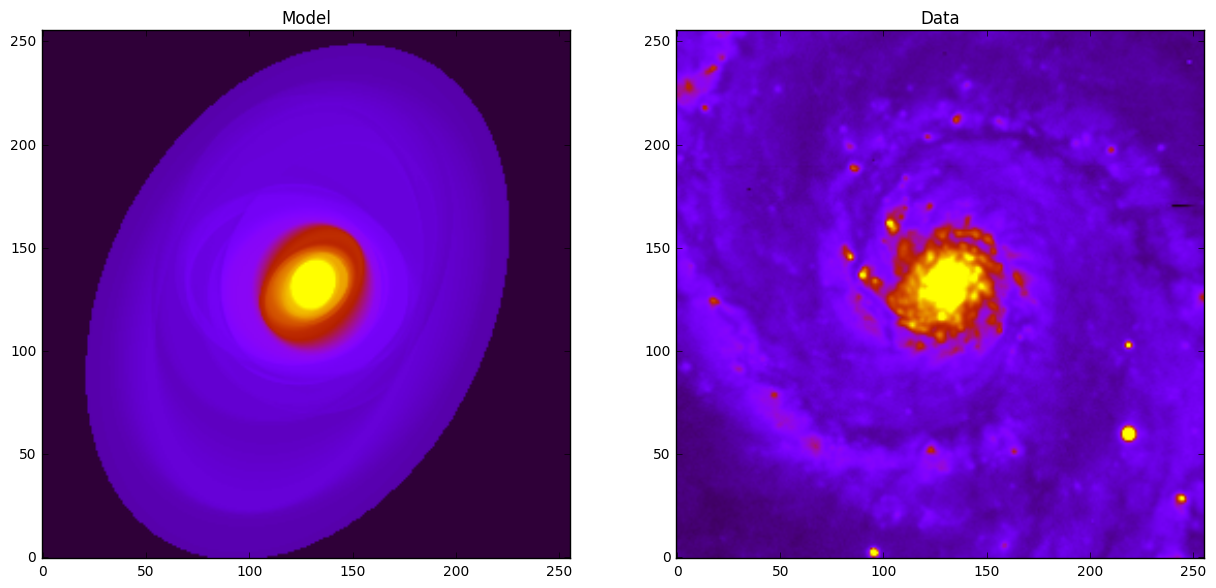

In [4]:
model = model_image[128:384,128:384]
data = pixel_data[128:384,128:384]

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
plt.rcParams['image.origin'] = 'lower'

plt.rcParams['figure.figsize'] = (15.0, 10.0)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(model, cmap=cm.gnuplot, vmin=0, vmax=1000)
ax1.set_title("Model")
ax2.imshow(data, cmap=cm.gnuplot, vmin=0, vmax=1000)
ax2.set_title("Data")


Finally, subtract model from data:


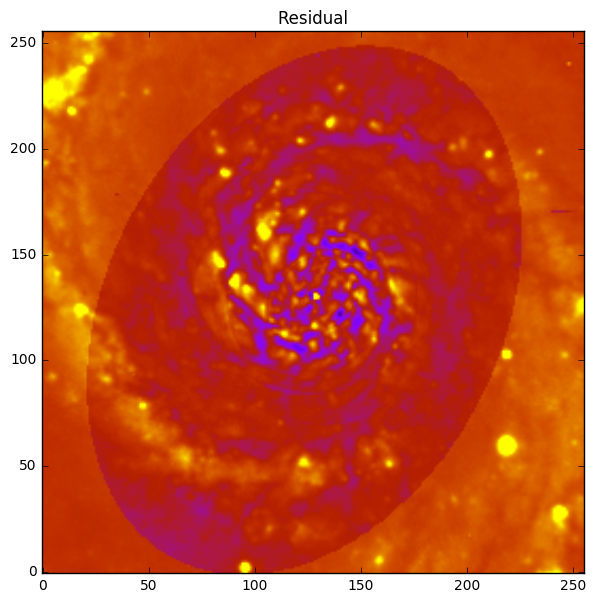

In [5]:
residual = data - model

plt.rcParams['figure.figsize'] = (10.0, 7.0)
fig, ax = plt.subplots()

ax.imshow(residual, cmap=cm.gnuplot, vmin=-300, vmax=300)
ax.set_title("Residual")

## Artificial image

Of course, M51 is not the best object to test this procedure, since the non-elliptical contamination is so significant.

In order to better evaluate the limits of the modeling, we can resort to an artificial image of a "perfectly" elliptical object. That way, at least we can check that the entire procedure: fit -> model -> residual is internally consistent.

We use the 'build_test_data' module in the 'util' package:

In [6]:
from util.build_test_data import build
from ellipse.geometry import Geometry

pixel_data = build(eps=0.5, pa=np.pi/3., background=10., noise=1.)

g = Geometry(256., 256., 10., 0.5, np.pi/3.)
ellipse = Ellipse(pixel_data, geometry=g)
isolist = ellipse.fit_image()
model_image = build_model(pixel_data, isolist, fill=np.mean(pixel_data[0:10,0:10]))
model = model_image
data = pixel_data
residual = data - model

Centering on object....   Done. Found x0 = 257.0, y0 = 257.0
#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
  10.00      953.54 ( 0.38)  0.496 (0.000)  60.00 ( 0.0)  0.004    44     0   20     0
  11.00      837.98 ( 0.28)  0.497 (0.000)  60.03 ( 0.0)  0.003    48     0   10     0
  12.10      733.67 ( 0.18)  0.497 (0.000)  60.04 ( 0.0)  0.003    53     0   10     0
  13.31      641.62 ( 0.14)  0.498 (0.000)  60.01 ( 0.0)  0.002    58     0   10     0
  14.64      559.20 ( 0.11)  0.498 (0.000)  59.96 ( 0.0)  0.002    64     0   10     0
  16.11      485.51 ( 0.12)  0.499 (0.000)  59.99 ( 0.0)  0.002    70     0   10     0
  17.72      420.41 ( 0.09)  0.499 (0.000)  59.97 ( 0.0)  0.002    77     0   10     0
  19.49      362.99 ( 0.07)  0.4

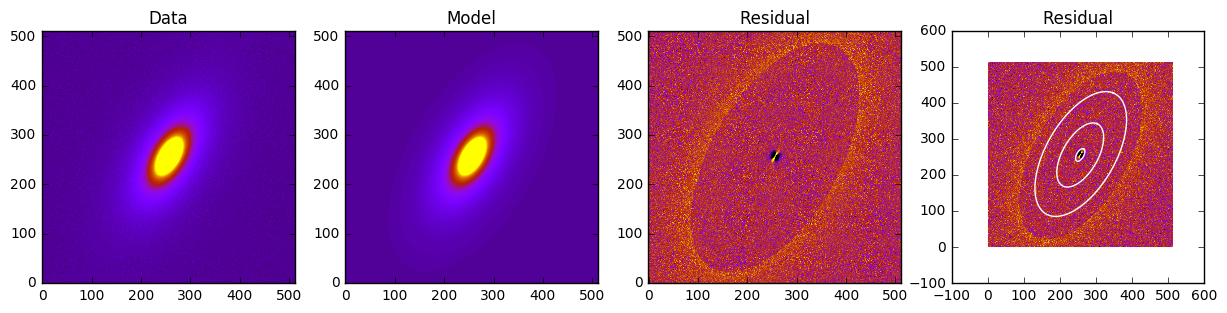

In [7]:
plt.rcParams['figure.figsize'] = (15.0, 10.0)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

ax1.imshow(data, cmap=cm.gnuplot, vmin=0., vmax=100)
ax1.set_title("Data")
ax2.imshow(model, cmap=cm.gnuplot, vmin=0., vmax=100)
ax2.set_title("Model")
ax3.imshow(residual, cmap=cm.gnuplot, vmin=-3, vmax=3)
ax3.set_title("Residual")
ax4.imshow(residual, cmap=cm.gnuplot, vmin=-3, vmax=3)
ax4.set_title("Residual")

iso1 = isolist.get_closest(20.)
iso2 = isolist.get_closest(100.)
iso3 = isolist.get_closest(200.)

x, y, = iso1.sampled_coordinates()
plt.plot(x, y, color='white')
x, y, = iso2.sampled_coordinates()
plt.plot(x, y, color='white')
x, y, = iso3.sampled_coordinates()
plt.plot(x, y, color='white')


### Analysis of central region

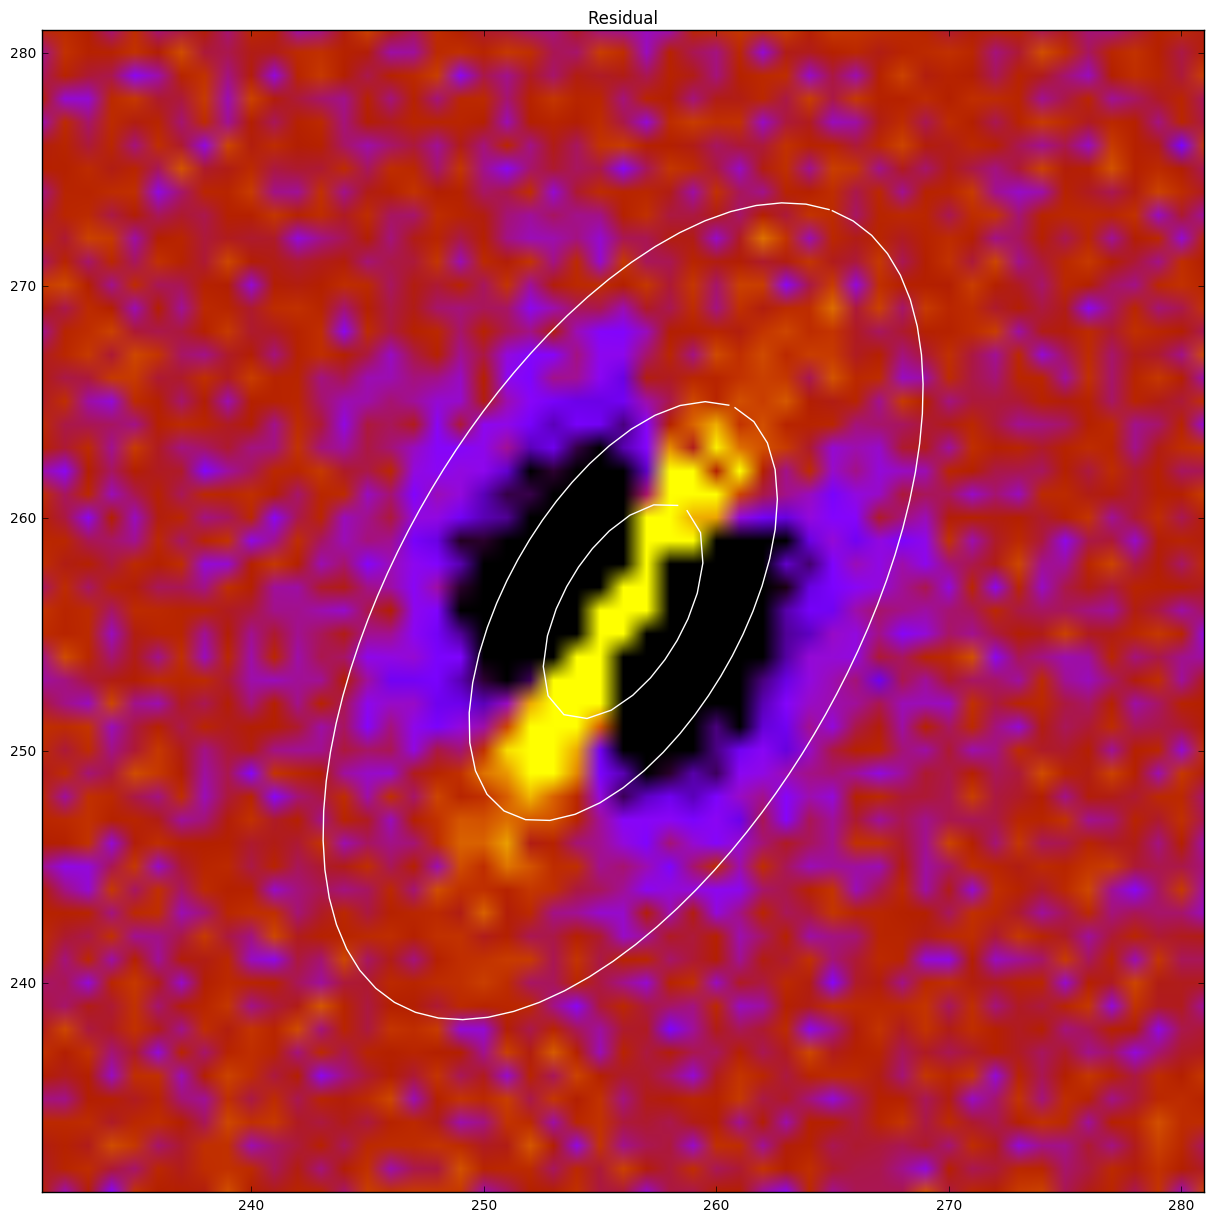

In [8]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)

fig, ax = plt.subplots()

# display center of image
plt.axis([256-25,256+25,256-25,256+25])

ax.imshow(residual, cmap=cm.gnuplot, vmin=-7, vmax=7)
ax.set_title("Residual")

iso1 = isolist.get_closest(5.)
iso2 = isolist.get_closest(10.)
iso3 = isolist.get_closest(20.)

x, y, = iso1.sampled_coordinates()
plt.plot(x, y, color='white')

x, y, = iso2.sampled_coordinates()
plt.plot(x, y, color='white')

x, y, = iso3.sampled_coordinates()
plt.plot(x, y, color='white')



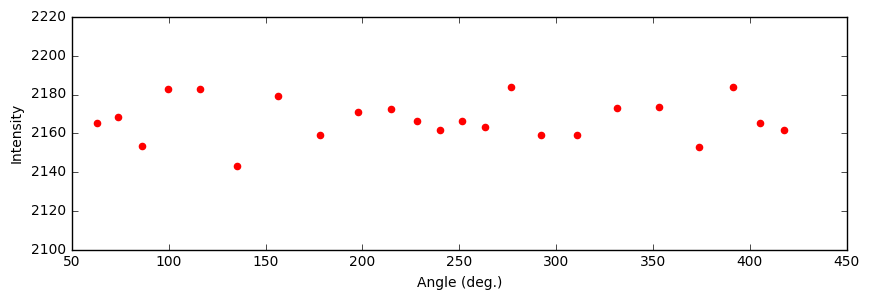

In [9]:
plt.rcParams['figure.figsize'] = (10.0, 3.0)

plt.axis([50.,450.,2100.,2220.])
plt.scatter((iso1.sample.values[0]+iso1.sample.geometry.pa)/np.pi*180., iso1.sample.values[2], color='red')
plt.ylabel("Intensity")
plt.xlabel("Angle (deg.)")

plt.axis([50.,450.,2100.,2220.])

plt.scatter((iso2.sample.values[0]+iso2.sample.geometry.pa)/np.pi*180., iso2.sample.values[2], color='black')


#plt.scatter((iso3.sample.values[0]+iso3.sample.geometry.pa)/np.pi*180., iso3.sample.values[2], color='blue')

